where there are two independent graphs and one graph is invoked in parent graph


![Separate SubGraphs Diagram](./separate.png)

In [36]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from dotenv import load_dotenv
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

In [37]:
load_dotenv()

True

In [38]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [39]:
subgraph_llm = ChatOllama(model="qwen3-vl:235b-instruct-cloud")

In [40]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

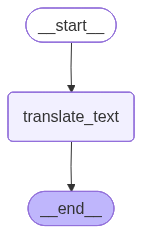

In [41]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()
subgraph

In [42]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [43]:
parent_llm = ChatOllama(model="qwen3-vl:235b-instruct-cloud")

In [44]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [45]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [ ]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)
graph = parent_builder.compile()
graph

ValueError: Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [49]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': '**Quantum physics** (also called **quantum mechanics** or **quantum theory**) is the branch of physics that studies the behavior of matter and energy at the smallest scales — typically at the level of atoms, electrons, photons, and other subatomic particles.\n\nUnlike classical physics (which describes the motion of everyday objects like cars or planets), quantum physics reveals that particles at the microscopic level behave in strange and counterintuitive ways. Some key ideas include:\n\n🔹 **Quantization**: Energy, momentum, and other properties are not continuous but come in discrete “packets” called quanta. (For example, electrons in atoms can only occupy specific energy levels.)\n\n🔹 **Wave-Particle Duality**: Particles like electrons and photons can behave both as particles (localized objects) and as waves (spread-out disturbances), depending on how you observe them.\n\n🔹 **Uncertainty Principle** (Heisenberg): You cannot sim